In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit_aer.noise import NoiseModel, depolarizing_error, phase_amplitude_damping_error

from qiskit_aer import AerError
from qiskit_aer import AerSimulator

def create_depol_noise_model(p_1q=0.01, p_2q=0.02, p_3q=0.03):
    """
    Create a noise model that adds:
      - Depolarizing error with probability p_1q on single-qubit gates
      - Depolarizing error with probability p_2q on two-qubit gates (e.g., CX)
      - Depolarizing error with probability p_3q on three-qubit gates (e.g., Toffoli/CCX)
    """
    noise_model = NoiseModel()

    error0 = phase_amplitude_damping_error(p_1q*1, p_1q*1)

    # 1-qubit depolarizing error
    error1 = depolarizing_error(p_1q, 1)
    # 2-qubit depolarizing error
    error2 = depolarizing_error(p_2q, 2)
    # 3-qubit depolarizing error
    error3 = depolarizing_error(p_3q, 3)
    
    # Apply 1-qubit error to typical single-qubit gates you use (including 'id')
    one_qubit_gates = ['x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'rx', 'ry', 'rz', 'id']
    for gate in one_qubit_gates:
        noise_model.add_all_qubit_quantum_error(error1, [gate])
        # noise_model.add_all_qubit_quantum_error(error0, [gate])
    
    # Apply 2-qubit error to 'cx' gate
    noise_model.add_all_qubit_quantum_error(error2, ['cx'])
    
    # Apply 3-qubit error to 'ccx' (Toffoli) gate
    noise_model.add_all_qubit_quantum_error(error3, ['ccx'])
    
    return noise_model

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector, state_fidelity

########################################################################
# 2.1. Basic Shor Encoding (Classical Implementation: 2 CNOTs, H, 6 CNOTs)
########################################################################

reg, clas_reg = None, None

def shor_encode_3(qc, qubits):

    # (1) Triple repetition for Z-error protection
    qc.cx(qubits[0], qubits[3])
    qc.cx(qubits[0], qubits[6])

def shor_encode_9(qc, qubits):
    """
    Encode qubits[0] into a block of 9 physical qubits.
    Steps (classical perspective):
     - 2 CNOTs for triple repetition
     - Hadamards
     - 6 CNOTs for the second repetition
    """
    # (2) For each of the 3 qubits above, do H + 2 CNOTs => total 3 * (1 H + 2 CNOTs) = 3 H + 6 CNOT
    # block 1: qubits[0] -> qubits[3], qubits[4]
    qc.h(qubits[0])
    qc.cx(qubits[0], qubits[1])
    qc.cx(qubits[0], qubits[2])
    
    # block 2: qubits[1] -> qubits[5], qubits[6]
    qc.h(qubits[3])
    qc.cx(qubits[3], qubits[4])
    qc.cx(qubits[3], qubits[5])
    
    # block 3: qubits[2] -> qubits[7], qubits[8]
    qc.h(qubits[6])
    qc.cx(qubits[6], qubits[7])
    qc.cx(qubits[6], qubits[8])
    return qc
    


########################################################################
# 2.2. Partial Decode to 3 "Logical" Qubits 
#     (Remove the H + 2*CNOT part only)
########################################################################

def shor_partial_decode(qc, qubits_9):
    """
    Invert the second-layer encoding on each triple block:
     - 2 CNOT + H
    Leaves us with 3 qubits that are still triple-repetition for Z-protection.
    We'll place them in qubits_9[0], qubits_9[1], qubits_9[2].
    The others become disentangled (ideally).
    """
    # block 1: [0,3,4]
    qc.cx(qubits_9[0], qubits_9[2])
    qc.cx(qubits_9[0], qubits_9[1])
    # qc.h(qubits_9[0])
    
    # block 2: [1,5,6]
    qc.cx(qubits_9[3], qubits_9[5])
    qc.cx(qubits_9[3], qubits_9[4])
    # qc.h(qubits_9[3])
    
    # block 3: [2,7,8]
    qc.cx(qubits_9[6], qubits_9[8])
    qc.cx(qubits_9[6], qubits_9[7])
    # qc.h(qubits_9[6])
    return qc


########################################################################
# 2.4. Full Decode from 9 qubits to 1 
#      (the triple repetition part => 2 CNOT)
########################################################################

def shor_final_decode(qc, qubits_9):
    """
    Remove the triple repetition for Z error protection.
    We do the inverse of '2 CNOTs' from the first step of encoding.
    After that, qubit[0] is the single recovered logical qubit.
    """
    qc.h(0)
    qc.h(3)
    qc.h(6)

    qc.cx(qubits_9[0], qubits_9[3])
    qc.cx(qubits_9[0], qubits_9[6])
    return qc

########################################################################
# 2.5. Utility: Toffoli among 3 qubits
########################################################################

def apply_3_toffoli_gates(qc, qubits_9):
    """
    Apply 3 distinct Toffoli gates among these 3 qubits in some pattern.
    For example:
      Toffoli(0,1 -> 2)
      Toffoli(0,2 -> 1)
      Toffoli(1,2 -> 0)
    """
    # Gate 1
    qc.ccx(qubits_9[2], qubits_9[1], qubits_9[0])
    # Gate 2
    qc.ccx(qubits_9[5], qubits_9[4], qubits_9[3])
    # Gate 3
    qc.ccx(qubits_9[8], qubits_9[7], qubits_9[6])
    return qc

def apply_one_toffoli_among_3(qc, qubits_3):
    """
    Apply one more Toffoli gate that uses the 3 qubits.
    Let's do a standard Toffoli(0,1->2).
    """
    qc.ccx(qubits_3[6], qubits_3[3], qubits_3[0])
    return qc

########################################################################
# 2.6. Full "Classical" Shor Code Circuit with 
#      - Encode (9 qubits total)
#      - Error in the middle
#      - Partial Decode => 3 logical qubits
#      - 3 Toffoli gates among them
#      - 1 more Toffoli among them
#      - Re-Encode => 9 qubits
#      - Final Decode => 1 qubit
########################################################################

def build_shor_toffoli_circuit(error_in_middle=False, p_bit=0, p_phase=0):
    global reg, clas_reg
    """
    Build a circuit that:
      1) Prepares a test state on qubit 0
      2) Fully encodes into 9 qubits
      3) (Optionally) applies an error or noise in the middle
      4) Partially decodes to get 3 logical qubits
      5) Apply 3 Toffoli gates among these 3 logical qubits
      6) Apply 1 more Toffoli among the same 3
      7) Re-encode them to get back 9 qubits
      8) Final decode to 1 qubit
      9) Measure

    We will test how well this pipeline corrects errors.
    """
    reg = QuantumRegister(9)
    clas_reg = ClassicalRegister(1)
    qc = QuantumCircuit(reg, clas_reg)
    
    # 1) Prepare an example single-qubit state (|0> + i|1>)/sqrt(2)
    
    

    init_circuit(qc)
    # qc.s(0)

    shor_encode_3(qc, range(9))

        # 2) Full encode to 9 qubits
    shor_encode_9(qc, range(9))

    
    # 3) An optional place to insert a single-qubit error 
    #    or rely on the noise model for gate errors.

    if error_in_middle:
        
        for i in range(9):
            if np.random.choice([False, True], p=[1-p_bit, p_bit]): qc.x(i)
            if np.random.choice([False, True], p=[1-p_phase, p_phase]): qc.z(i)

        # qc.z(0)
        # qc.z(1)
        # Example: X error on qubit 4
        
        # qc.x(0)
        # qc.z(0)
        # qc.z(1)
        # qc.id(2)
        # qc.id(3)
        # qc.id(4)
        # qc.x(5)
        # qc.id(6)
        # qc.id(7)
        # qc.id(8)

        # qc.z(0)
        # qc.z(4)
        # qc.id(8)

        pass
    
    # 4) Partial decode => 3 logical qubits are [0,1,2]
    shor_partial_decode(qc, range(9))
    
    # 5) 3 Toffoli gates among qubits [0,1,2]
    apply_3_toffoli_gates(qc, range(9))

    # 8) Final decode => single qubit is qubit 0
    shor_final_decode(qc, range(9))
    
    # 6) 1 more Toffoli among these 3
    apply_one_toffoli_among_3(qc, range(9))

    simulated_state = Statevector.from_instruction(qc)

    # qc.x(1)
    # qc.x(2)
    # qc.h(4)
    # qc.h(5)
    # qc.h(7)
    # qc.h(8)

    qc.save_density_matrix()
    
    # # 9) Measure
    # for num, i in enumerate([0]):
    # # for num, i in enumerate([0, 3, 6]):
    # # for num, i in enumerate([0, 1, 2]):
    #     qc.measure(i, num)
    
    return qc, simulated_state

def build_no_corr_circuit(error_in_middle=False, p_bit=0, p_phase=0):
    global no_corr_reg

    no_corr_reg = QuantumRegister(1)
    no_corr_clas_reg = ClassicalRegister(1)
    qc = QuantumCircuit(no_corr_reg, no_corr_clas_reg)

    init_circuit(qc)

    if error_in_middle:
        if np.random.choice([False, True], p=[1-p_bit, p_bit]): qc.x(0)
        if np.random.choice([False, True], p=[1-p_phase, p_phase]): qc.z(0)

    for i in range(100):
        qc.id(0)

    simulated_state = Statevector.from_instruction(qc)

    qc.save_density_matrix()
    # qc.measure(0, 0)
    
    return qc, simulated_state


def init_circuit(qc):
    # qc.h(0)
    # qc.rz(np.pi/4, 0)
    qc.h(0)

    qc.s(0)

    return qc



In [3]:


from qiskit.quantum_info import DensityMatrix

def run_density_matrix_sim_with_noise(qc, noise_model):
    """
    Run the given circuit 'qc' on the density_matrix simulator with 'noise_model'.
    Return the final density matrix as a DensityMatrix object.
    """
    simulator = QasmSimulator(method='density_matrix',
                        noise_model=noise_model)

    result = simulator.run(qc).result()

    final_rho = result.data()["density_matrix"]
    # It's returned as a list or np.array. We can wrap it in qiskit DensityMatrix:
    final_dm = DensityMatrix(final_rho)
    return final_dm

p-values: [0.         0.00222222 0.00444444 0.00666667 0.00888889 0.01111111
 0.01333333 0.01555556 0.01777778 0.02      ]
Fidelity (With Code): [1.0000000000000004, 0.9513071190541754, 0.9071612820292028, 0.8671561772701047, 0.8309201527695876, 0.7981134022573309, 0.7684253671337282, 0.7415723395470161, 0.7172952519171032, 0.6953576391960635]
Fidelity (No Code):   [1.0000000000000004, 0.8984927145519012, 0.8174322400500076, 0.752732427163618, 0.7011171937616493, 0.6599612303225934, 0.6271617722747092, 0.6010354315965305, 0.580235230965065, 0.5636839170998809]


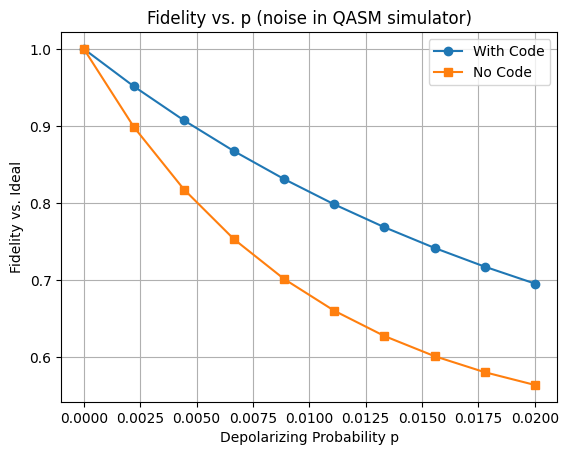

In [4]:
# First, import all the useful methods

import numpy as np
import matplotlib.pyplot as plt   
import math


from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import partial_trace, state_fidelity


## Noise model
from qiskit_aer import QasmSimulator
import qiskit_aer.noise as noise


## To visualize density matrices
from qiskit.visualization import plot_state_city

def get_ideal_target_dm():
    """
    Build the 'ideal' state with no noise, no random error. 
    We'll create exactly the same final circuit steps, but on the ideal simulator
    (or we can do it by logic).
    Then extract its final density matrix.
    """
    qc_ideal, ideal_sv = build_shor_toffoli_circuit(
        error_in_middle=False, 
        p_bit=0, 
        p_phase=0
    )

    simulator = QasmSimulator(method='density_matrix')

    result = simulator.run(qc_ideal).result()
    final_rho = result.data()["density_matrix"]
    rho_ideal = DensityMatrix(final_rho)
    return rho_ideal

def fidelity_sweep():
    # 1) get the ideal final density matrix
    rho_target = get_ideal_target_dm()
    
    # We pick which qubits we care about partial tracing out:
    # If your final code qubit is index 0, you might trace out [1..8].
    # Or if you want the entire 9-qubit state, you don't have to partial-trace. 
    # For the "no code" circuit, you have only 1 qubit anyway.
    # We'll assume your code wants to see just qubit 0's reduced state.
    qubits_to_discard = list(range(1,9))  # if 9 qubits total

    p_vals = np.linspace(0, 0.02, 10)
    results_code = []
    results_no_code = []
    
    for p in p_vals:
        noise_model = create_depol_noise_model(p_1q=p, p_2q=2*p, p_3q=3*p)

        # --- With code ---
        qc_code, _ = build_shor_toffoli_circuit(
            error_in_middle=False, 
            p_bit=0, 
            p_phase=0
        )
        qc_code.remove_final_measurements()  # so we get the full final state
        rho_code = run_density_matrix_sim_with_noise(qc_code, noise_model)
        # partial trace out qubits 1..8, keep qubit 0
        rho_code_dm = DensityMatrix(rho_code)
        rho_code_reduced = partial_trace(rho_code_dm, qubits_to_discard)
        
        # fidelity with the target state's reduced DM
        rho_target_reduced = partial_trace(rho_target, qubits_to_discard)
        fid_code = state_fidelity(rho_target_reduced, rho_code_reduced)
        results_code.append(fid_code)
        
        # --- No code ---
        # we apply identity gates to approximate the same depth
        # let's guess ~12 or 15 gates or more. 
        # or you can do len(qc_code) to see how many gates it has 
        # and replicate that number of `id(0)` in the no-code circuit.
        qc_no_code, _ = build_no_corr_circuit()
        qc_no_code.remove_final_measurements()
        rho_no_code = run_density_matrix_sim_with_noise(qc_no_code, noise_model)
        # It's 1 qubit, no partial trace needed
        fid_no_code = state_fidelity(rho_target_reduced, rho_no_code)
        results_no_code.append(fid_no_code)
    
    # Print or plot
    print("p-values:", p_vals)
    print("Fidelity (With Code):", results_code)
    print("Fidelity (No Code):  ", results_no_code)
    
    # optionally plot
    import matplotlib.pyplot as plt
    plt.plot(p_vals, results_code, 'o-', label='With Code')
    plt.plot(p_vals, results_no_code, 's-', label='No Code')
    plt.xlabel("Depolarizing Probability p")
    plt.ylabel("Fidelity vs. Ideal")
    plt.legend()
    plt.title("Fidelity vs. p (noise in QASM simulator)")
    plt.grid(True)
    plt.show()

# Finally:
fidelity_sweep()